# Part 1: Analyze the Network

## Introduction

This analysis examines a directed network of rock performers extracted from Wikipedia, where nodes represent bands or artists and directed edges indicate hyperlinks between their Wikipedia pages. The network contains 484 nodes and 7,323 directed edges. Each node has a `content_length` attribute indicating the character count of the corresponding Wikipedia page.

Using tools from Lecture 5, we characterize the network structure through visualization (using build in ForceAtlas2 method in `networkx` library), centrality measures (degree, betweenness, eigenvector), assortativity analysis, power-law distribution fitting, and network backbone extraction. This analysis builds upon basic degree distributions from previous week for a more comprehensive structural analysis.

The directed nature of links in Wikipedia networks carries important semantic meaning. When band A links to band B, this connection reflects documented relationships such as shared tours, members, labels, or influences. However, the reverse link may not exist, creating asymmetry that distinguishes in-degree from out-degree. In-degree reflects prestige or fame, how many other pages mention a particular band. While out-degree reflects documentation scope of how comprehensively a band's own page documents related entities. This distinction is crucial because Wikipedia is opensource and edited by people, ith their own editorial choices, historical importance, and documentation practices.


## Data Setup

We load the rock band network from the pre-processed data file. The graph is a directed network where edges represent Wikipedia hyperlinks between artist pages. Isolated nodes have been removed, resulting in a single weakly connected component. We work with both the directed version (for in/out-degree analysis) and the undirected version (for centrality and other measures that require undirected graphs).


In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import requests
import io
from scipy import stats
import seaborn as sns

In [2]:
local_network = "../data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/rock_graph_node_link.json.gz"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

# remove isolated nodes
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)

print(f"Loaded directed graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.")
print(f"Isolated nodes removed: {len(isolated_nodes)}")
print(f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}")

# making an undirected version
G_und = G_bands.to_undirected()
largest_cc = max(nx.connected_components(G_und), key=len)
G_gcc = G_und.subgraph(largest_cc).copy()

print(f"\nUndirected version: {G_und.number_of_nodes()} nodes and {G_und.number_of_edges()} edges")
print(f"Giant Connected Component: {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


Loaded directed graph with 484 nodes and 7323 edges.
Isolated nodes removed: 4
Graph component count: 1

Undirected version: 484 nodes and 6019 edges
Giant Connected Component: 484 nodes and 6019 edges


## Network Visualization with ForceAtlas2

Network visualization provides an intuitive representation of global structure that complements numerical measures. ForceAtlas2 just offers a more readable layout than traditional algorithms.

We visualize the network using NetworkX's built-in ForceAtlas2 layout algorithm as suggested in week5 lecture. In this plot, node size is proportional to degree, allowing prominent nodes with many connections to be easily seen, while node color represents the `content_length` attribute, roughly showing patterns in how bands are documented across the network.

In [3]:
pos_fa2 = nx.forceatlas2_layout(G_gcc, linlog=True, max_iter=500, seed=42)

/Users/rifo/miniforge3/envs/dtu02452/lib/python3.11/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


In [4]:
# prep node attributes for visualization
degrees_gcc = dict(G_gcc.degree())
node_sizes = [degrees_gcc[n] * 7 for n in G_gcc.nodes()]  #  scale to have better visual representation (we decided to go with 7)
content_lengths = [G_gcc.nodes[n].get("content_length", 0) for n in G_gcc.nodes()]

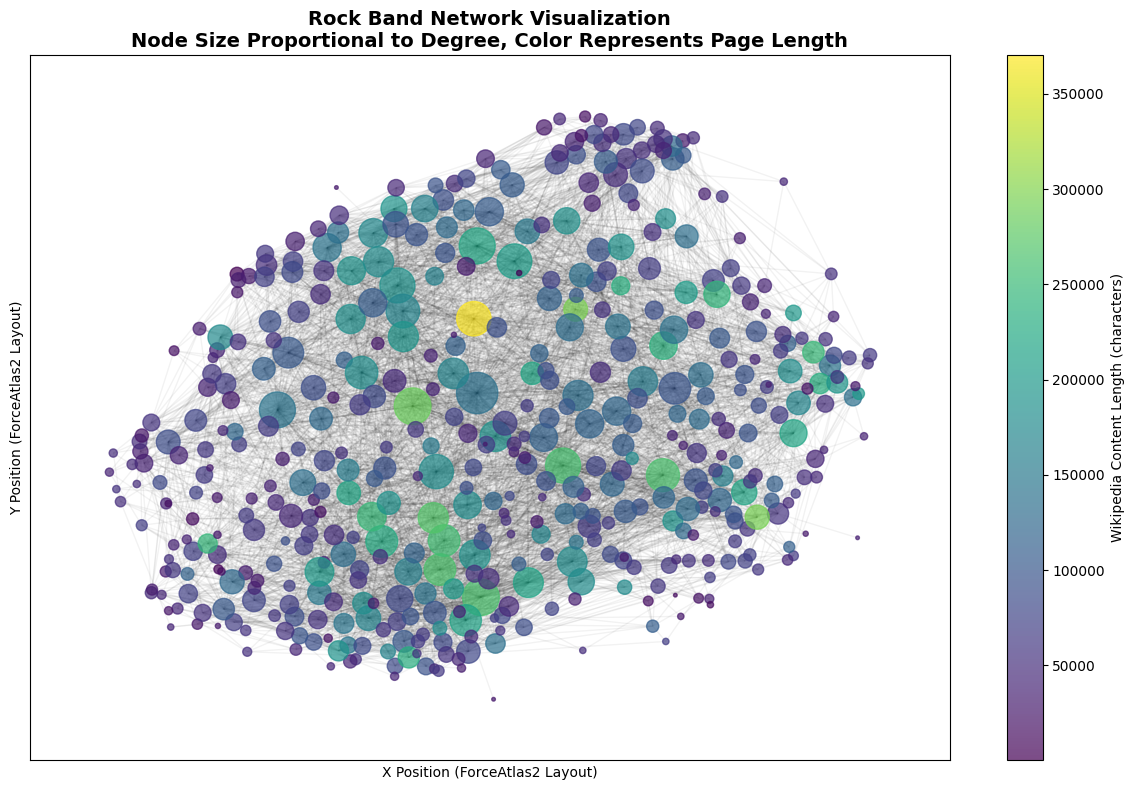

Visualization created with 484 nodes and 6019 edges


In [5]:
plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(
    G_gcc,
    pos_fa2,
    node_size=node_sizes,
    node_color=content_lengths,
    cmap=plt.cm.viridis,
    alpha=0.7
)
nx.draw_networkx_edges(G_gcc, pos_fa2, alpha=0.05, width=1, edge_color="black")

cbar = plt.colorbar(nodes, label="Wikipedia Content Length (characters)")
plt.xlabel("X Position (ForceAtlas2 Layout)")
plt.ylabel("Y Position (ForceAtlas2 Layout)")
plt.title(
    "Rock Band Network Visualization\nNode Size Proportional to Degree, Color Represents Page Length",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"Visualization created with {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


> **Figure 1** shows the network visualization using ForceAtlas2 layout. The spatial arrangement reveals clustering patterns and community structure, with larger nodes indicating bands that have more connections. The color gradient shows that bands with longer Wikipedia pages (warmer colors) are usually more connected in contrast with smaller and less connected pages, suggesting that documentation comprehensiveness and network position are related.


## Basic Network Structure

For directed networks such as Wikipedia, in-degree and out-degree must be analyzed separately because they capture different semantic meanings. In-degree reflects prestige or fame, how many other pages link to a particular band, indicating historical importance or influence. Out-degree reflects documentation scope, how comprehensively a band's own page documents related entities, which may be influenced by editorial practices and page comprehensiveness rather than historical importance alone.


In [6]:
# degree statistics for directed graph
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())
in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())


In [7]:
def calculate_mode(values):
    mode_result = stats.mode(values, keepdims=True)
    return mode_result.mode[0] if len(mode_result.mode) > 0 else None


In [8]:
print("In-Degree Statistics:")
print(f"  Mode:   {calculate_mode(in_deg_values)}")
print(f"  Min:    {np.min(in_deg_values)}")
print(f"  Max:    {np.max(in_deg_values)}")
print(f"  Std Dev: {np.std(in_deg_values):.2f}")

print("\nOut-Degree Statistics:")
print(f"  Mode:   {calculate_mode(out_deg_values)}")
print(f"  Min:    {np.min(out_deg_values)}")
print(f"  Max:    {np.max(out_deg_values)}")
print(f"  Std Dev: {np.std(out_deg_values):.2f}")

In-Degree Statistics:
  Mode:   3
  Min:    0
  Max:    119
  Std Dev: 17.00

Out-Degree Statistics:
  Mode:   12
  Min:    0
  Max:    74
  Std Dev: 10.63


To get a better understanding lets also look at correlation and degree distribution

In [9]:
# calculate correlation
correlation = np.corrcoef(out_deg_values, in_deg_values)[0, 1]

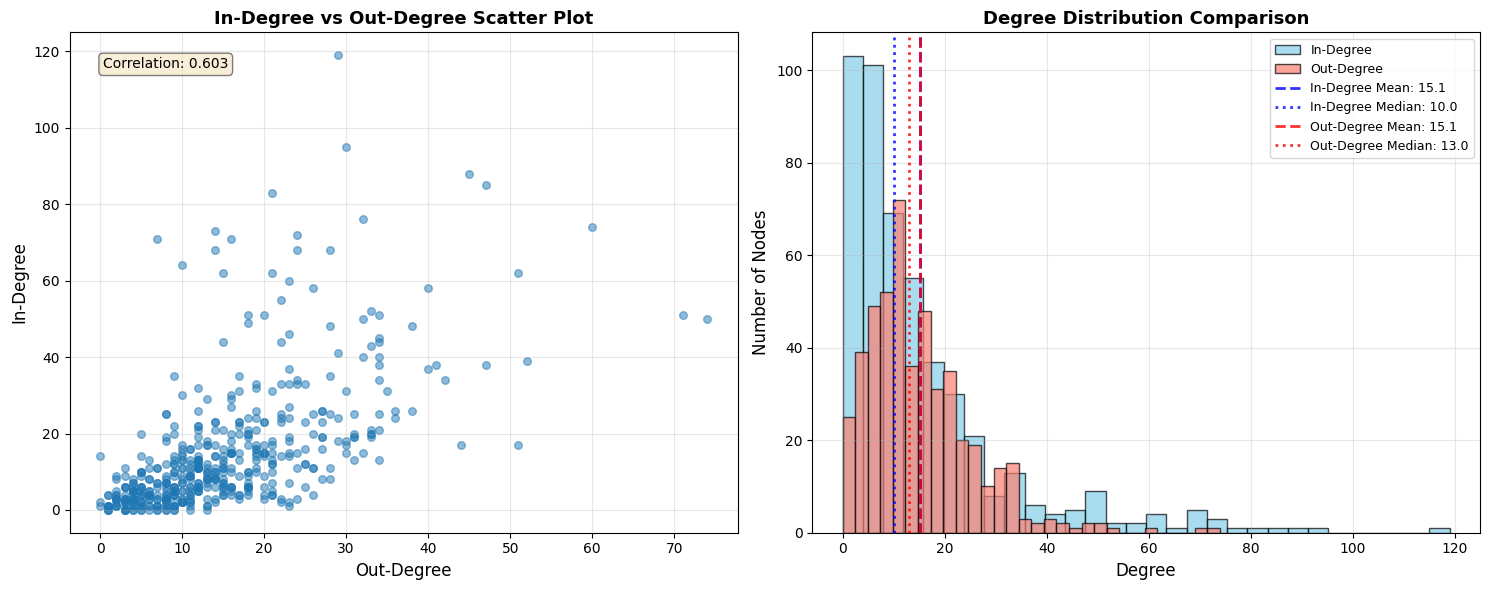

Correlation between in-degree and out-degree: 0.603


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# scatter plot
axes[0].scatter(out_deg_values, in_deg_values, alpha=0.5, s=30)
axes[0].set_xlabel("Out-Degree", fontsize=12)
axes[0].set_ylabel("In-Degree", fontsize=12)
axes[0].set_title("In-Degree vs Out-Degree Scatter Plot", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)

# correlation coefficient
axes[0].text(0.05, 0.95, f"Correlation: {correlation:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# histogram of degree distributions
axes[1].hist(in_deg_values, bins=30, alpha=0.7, label="In-Degree", color="skyblue", edgecolor="black")
axes[1].hist(out_deg_values, bins=30, alpha=0.7, label="Out-Degree", color="salmon", edgecolor="black")

# vertical lines for mean and median
in_mean = np.mean(in_deg_values)
in_median = np.median(in_deg_values)
out_mean = np.mean(out_deg_values)
out_median = np.median(out_deg_values)

axes[1].axvline(in_mean, color="blue", linestyle="--", linewidth=2, label=f"In-Degree Mean: {in_mean:.1f}", alpha=0.8)
axes[1].axvline(in_median, color="blue", linestyle=":", linewidth=2, label=f"In-Degree Median: {in_median:.1f}", alpha=0.8)
axes[1].axvline(out_mean, color="red", linestyle="--", linewidth=2, label=f"Out-Degree Mean: {out_mean:.1f}", alpha=0.8)
axes[1].axvline(out_median, color="red", linestyle=":", linewidth=2, label=f"Out-Degree Median: {out_median:.1f}", alpha=0.8)

axes[1].set_xlabel("Degree", fontsize=12)
axes[1].set_ylabel("Number of Nodes", fontsize=12)
axes[1].set_title("Degree Distribution Comparison", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between in-degree and out-degree: {correlation:.3f}")


> **Figure 2** shows the relationship between in-degree and out-degree through a scatter plot and histogram comparison. The degree statistics reveal that in-degree has mode 3, maximum 119, and standard deviation 17.00, while out-degree has mode 12, maximum 74, and standard deviation 10.63. Both distributions share mean values of 15.1, but their modes and medians differ significantly.
>
> The scatter plot reveals a moderate positive correlation (0.603), indicating that bands with many outgoing links tend to receive more incoming links. Most nodes are clustered near the origin, with 322 out of 484 nodes (66.5%) falling within the [0,20] × [0,20] degree range. However, there is a notable spread extending towards higher degrees, with some nodes reaching in-degrees up to nearly 120 and out-degrees up to around 70. The histogram comparison shows that while both distributions are right-skewed, out-degrees are slightly shifted towards higher values compared to in-degrees, suggesting that bands tend to document more related entities than they are referenced by others on average. This suggests that comprehensive documentation often correlates with greater recognition, though the imperfect correlation indicates these measures capture distinct aspects.

## Content Length and Documentation Patterns

## Power-Law Distribution Analysis


## Centrality Analysis: Multiple Perspectives on Node Importance


## Assortativity: Mixing Patterns

Assortativity measures whether similar nodes connect to similar nodes (homophily) or dissimilar nodes (heterophily), revealing patterns in how the network organizes itself.
